# Latent Space Exploration (Dimensionality Reduction)

This notebook is for **exploration + plots**.
For reproducible outputs, use the companion script: `reduce_embeddings.py`.


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

try:
    import umap
    HAS_UMAP = True
except Exception:
    HAS_UMAP = False
    print('UMAP not found. Install with: pip install umap-learn')

print('UMAP available:', HAS_UMAP)


c:\CLIP Farming\video-virality-predictor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP available: True


In [3]:
FUSED_PATH = r"C:\CLIP Farming\video-virality-predictor\Data\Fusion\fused.pt"
OUT_DIR = 'latent_space_outputs'
PLOTS_DIR = os.path.join(OUT_DIR, 'plots')
os.makedirs(PLOTS_DIR, exist_ok=True)

X = torch.load(FUSED_PATH, map_location='cpu')
if isinstance(X, dict):
    for k in ['embeddings','fused','X']:
        if k in X:
            X = X[k]
            break
X = X.detach().float()
Xn = X / (X.norm(dim=1, keepdim=True) + 1e-12)
Xn = Xn.numpy()
print('Loaded normalized:', Xn.shape)


Loaded normalized: (222, 512)


In [4]:
def knn_indices(X_arr, k=15):
    nn = NearestNeighbors(n_neighbors=k+1)
    nn.fit(X_arr)
    inds = nn.kneighbors(X_arr, return_distance=False)
    return inds[:,1:]

def neighborhood_overlap(X_high, X_low, k=15):
    hi = knn_indices(X_high, k)
    lo = knn_indices(X_low, k)
    return float(np.mean([len(set(hi[i]).intersection(set(lo[i])))/k for i in range(hi.shape[0])]))


c:\CLIP Farming\video-virality-predictor\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\CLIP Farming\video-virality-predictor\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\CLIP Farming\video-virality-predictor\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2800.0_x64__qbz5n2kfra8p0\Lib

Overlap PCA20 vs PCA50 @15: 0.629


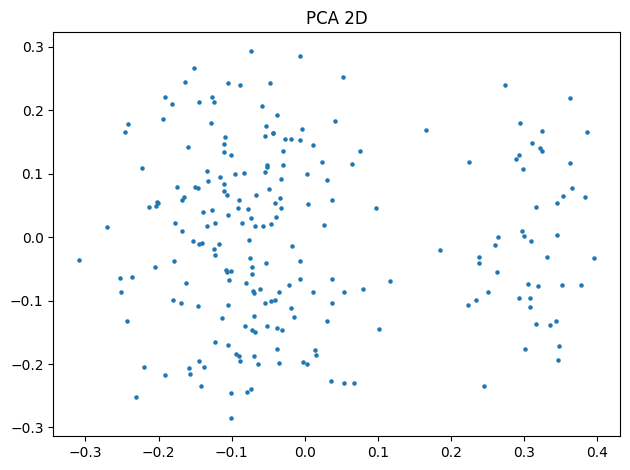

In [5]:
# PCA base
pca50 = PCA(n_components=50, random_state=42).fit_transform(Xn)
pca20 = PCA(n_components=20, random_state=42).fit_transform(Xn)
print('Overlap PCA20 vs PCA50 @15:', round(neighborhood_overlap(pca50, pca20, 15), 3))

# Quick PCA 2D plot
pca2 = PCA(n_components=2, random_state=42).fit_transform(Xn)
plt.figure()
plt.scatter(pca2[:,0], pca2[:,1], s=5)
plt.title('PCA 2D')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'pca_2d.png'), dpi=200)
plt.show()


c:\CLIP Farming\video-virality-predictor\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


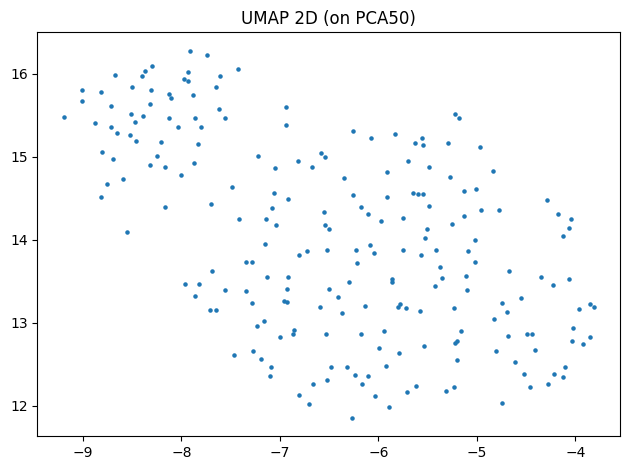

In [6]:
# UMAP 2D visualization (if available)
if HAS_UMAP:
    reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1, random_state=0)
    umap2 = reducer.fit_transform(pca50)
    plt.figure()
    plt.scatter(umap2[:,0], umap2[:,1], s=5)
    plt.title('UMAP 2D (on PCA50)')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, 'umap_2d.png'), dpi=200)
    plt.show()
else:
    print('UMAP not installed; run the script for t-SNE fallback or install umap-learn.')


In [ ]:
# --- Save clustering spaces (both PCA-only and PCA->UMAP) ---

import numpy as np
import os
from sklearn.decomposition import PCA

# Make sure these variables already exist from earlier cells:
# - Xn (normalized embeddings, numpy) OR Xn as torch tensor already converted to numpy
# - pca50 (PCA(50) output)

OUT_DIR = 'Latence/latent_space_outputs'
EMB_DIR = os.path.join(OUT_DIR, 'embeddings')
os.makedirs(EMB_DIR, exist_ok=True)

# 1) PCA-only clustering space (20D)
pca20 = PCA(n_components=20, random_state=42).fit_transform(Xn)
np.save(os.path.join(EMB_DIR, "cluster_pca20.npy"), pca20)
print("Saved:", os.path.join(EMB_DIR, "cluster_pca20.npy"), pca20.shape)

# 2) PCA->UMAP clustering space (15D) using your working UMAP setup
import umap
umap15 = umap.UMAP(
    n_components=15,
    n_neighbors=50,
    min_dist=0.1,
    metric="euclidean",
    random_state=0
).fit_transform(pca50)

np.save(os.path.join(EMB_DIR, "cluster_pca50_umap15.npy"), umap15)
print("Saved:", os.path.join(EMB_DIR, "cluster_pca50_umap15.npy"), umap15.shape)


Saved: latent_space_outputs\embeddings\cluster_pca20.npy (222, 20)


c:\CLIP Farming\video-virality-predictor\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: latent_space_outputs\embeddings\cluster_pca50_umap15.npy (222, 15)
